# Problem Set 2
_MaCSS 222 Applied Statistics II_
_Spring 2025_

This Problem Set will, like the first problem set utilize an extract from the 1997 cohort of the National Longitudinal Survey of Youth (NLSY97). This Notebook is designed to help you get started. Serving as a stub for your own solutions, completing the problem set will involve adding code and commentary to this notebook. Narrative answers to questions posed in the Problem Set can be included in markdown boxes in this notebook. For "pencil and paper" calculations you can either hand-write your answers and turn in a pdf-scan of them along with your Python Jupyter Notebook, or you can write you answers in LaTex in markdown boxes. Please see the pdf file for Problem Set 1 for instructions.
<br>
<br>
If you are not already familiar with LaTex, I encourage you to learn the basics. Overleaf is a helpful online editing environment for LaTex which you can access as a UC Berkeley community member.
<br>
<br>
The goals of this particular problem set are two fold. First, to review the basics of logistic regression analysis. Second, to gain practice using the boostrap in more complicated settings -- settings where traditional (i.e., analytic) methods of confidence interval and standard error construction are not possible.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

## Part I: Load NLSY97 extract

In [2]:
# Directory where NLSY97 teaching extract file is located
data =  '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Data/'

# Directory to save graphics files in
graphics = '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Graphics/'

# Load NLSY97 dataset
nlsy97 = pd.read_csv(data+'nlsy97ss.csv') # Reading .csv as DataFrame

# Rename some columns and then form new dataframe with complete cases for key variables
nlsy97.rename(columns={'avg_earn_2016_to_2020': 'earnings', 'hgc_at_age28': 'yrssch'}, inplace=True)

# Look at first few rows of dataset
nlsy97[0:5]

,hhid97,pid97,swgt,cs_smpl,earnings,yrssch,asvab,female,black,hispanic,birth_month,birth_year
0,2,2,272178,1,140764.964069,14.0,58.483,0,0,1,July,1982
1,3,3,169357,1,34487.266323,14.0,27.978,1,0,1,September,1983
2,4,4,149099,1,45864.738658,13.0,37.012,1,0,1,February,1981
3,8,6,218371,1,23202.102210,14.0,22.001,1,0,1,January,1982
4,8,7,232055,1,0.000000,12.0,3.585,0,0,1,April,1983


## Part II: Predicting college attendance among those who have completed high school

We are interested in building a simple model for whether an individual completes a 4-year college degree or not. Since a pre-requisite for attending college is complete high school, we will confine our analysis to the subset of NLSY97 respondents who have completed high school. 

### 1.1 Data Cleaning

In [5]:
# Find subset of respondents who completed high school; drop any remaining units with item non-response
nlsy97 = nlsy97[(nlsy97['yrssch']>=12)]
nlsy97 = nlsy97.dropna()

# Create dummy variable for completion of a 4-year degree (by age 28)
nlsy97['college'] = 1*(nlsy97['yrssch']>=16)

### 1.2 Quintiles

The pandas "cuts" command (used above), in conjunction with pandas "crosstab" command (used below), is very useful for explorating data analysis. Below we see that the [Armed Services Vocational Aptitude Battery (ASVAB)](https://nationalguard.com/practice-asvab) is highly predictive of college attendance. Among NLSY97 high school graduates, those with top-quartile asvab scores attended college at a rate of 65 percent, while those with bottom-quartile scores attend at a rate of 9 percent.

In [6]:
# Create asvab test score bins
# Define bins and labels
bins = [0, 20, 40, 60, 80, 100]
labels = ['asvab_Q1', 'asvab_Q2', 'asvab_Q3', 'asvab_Q4', 'asvab_Q5']
nlsy97['asvab_level'] = pd.cut(nlsy97['asvab'], bins=bins, labels=labels, right=False)

# Add constant to the dataframe
nlsy97['intercept']=1

# College attendance by asvab quartile
pd.crosstab(nlsy97['college'], nlsy97['asvab_level'], normalize='columns', margins=True)

asvab_level,asvab_Q1,asvab_Q2,asvab_Q3,asvab_Q4,asvab_Q5,All
college,,,,,,
0,0.930683,0.812099,0.683633,0.522954,0.309623,0.656598
1,0.069317,0.187901,0.316367,0.477046,0.690377,0.343402


Discuss this cross-tab? 
* The table presents the relationship between ASVAB scores (divided into quintiles) and college completion rates.
* Each column represents a different ASVAB score range, while the rows show the proportion of individuals who did (college = 1) or did not (college = 0) complete a 4-year college degree.
* The overall trend suggests that individuals with higher ASVAB scores are more likely to complete college.

How does the frequency of college completion vary across sub-populations with diﬀerent asvab scores? 
* College completion rates increase as ASVAB scores rise.
* In ASVAB Q1 (lowest 20%), only 6.9% completed college, whereas in ASVAB Q5 (highest 20%), 69.0% completed college.
* The likelihood of college completion is significantly lower for individuals with low ASVAB scores, suggesting a strong correlation between cognitive ability and higher education success.

How does the distribution of asvab scores diﬀer across college and non-college graduates?
* Among non-college graduates (college = 0), the majority have lower ASVAB scores, with 93.1% in Q1 and 81.2% in Q2 not completing college.
* Among college graduates (college = 1), higher ASVAB scores are more common, with 69.0% in Q5 and 47.7% in Q4.
* This indicates that individuals with higher ASVAB scores are not only more likely to complete college but also make up a larger proportion of the college-educated population.

### 1.3 Logistic Regression

Next we fit a simple logistic regression model for college attendance with gender, race and asvab score as predictors. Note the values of the "solver" and "penality" parameters in the sklearn LogisticRegression call. This is a textbook implementation.

The confusion matrix provides a simple measure of in sample prediction accuracy. We can also construct such a matrix for prediction accuracy in a hold-out sample.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

# Construct and display confusion matrix
results = pd.DataFrame(model.coef_.reshape((-1,1)), index=X.columns.values, columns=['Coefficient'])


# Display full regression summary
print("Logistic Regression Results for College Attendence")
print("")
print(results)

matrix = confusion_matrix(nlsy97['college'], model.predict(X))

# Row and column labels
row_labels = ['College', 'High School']
col_labels = ['College (Pred)', 'High School (Pred)']

# Construct and display confusion matrix
matrix = pd.DataFrame(matrix, index=row_labels, columns=col_labels)
print("Confusion Matrix")
print("")
print(matrix)

Logistic Regression Results for College Attendence

           Coefficient
intercept    -3.039104
female        0.451547
black         0.004648
hispanic     -0.186052
asvab         0.040294
Confusion Matrix

             College (Pred)  High School (Pred)
College                2787                 517
High School             793                 935


## Part III: Bootstrap inference on average partial effect (APE) of Asvab percentile score

Our next task is to use our logit results to construct average partial (or average marginal) effect estimates. We will then use the bootstrap to construct confidence intervals and standard errors for them. For a general model the logit choice probability equals:
$$
\Pr\left(\left.Y=1\right.X=x\right)=\frac{\exp\left(x'\gamma\right)}{1+\exp\left(x'\gamma\right)}=\frac{\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}{1+\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)},
$$
The effect of an incremental increase in $X_k$, the k-th regressor, on the conditional probability that $Y=1$ equals:
$$
\frac{\partial\Pr\left(\left.Y=1\right.X=x\right)}{\partial x_{k}}=\frac{\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}{1+\exp\left(\alpha+\beta_{1}x_{1}+\cdots+\beta_{K}x_{K}\right)}\beta_{k}.
$$
This expression is a function of $x$. To get a summary measure we average over the marginal distribution of $X$ to get:
$$
\delta_{k}^{\mathrm{APE}}=\mathbb{E}_{X}\left[\frac{\partial\Pr\left(\left.Y=1\right.X\right)}{\partial X_{k}}\right]=\mathbb{E}_{X}\left[\frac{\exp\left(\alpha+\beta_{1}X_{1}+\cdots+\beta_{K}X_{K}\right)}{1+\exp\left(\alpha+\beta_{1}X_{1}+\cdots+\beta_{K}X_{K}\right)}\beta_{k}\right].
$$
We can estimate this object by replacing the unknown logit coefficients with our maximum likelihood estimates and the expectation over the marginal distribution of $X$ with the sample average. This yields:
$$
\hat{\delta}_{k}^{\mathrm{APE}}=\frac{1}{N}\sum_{i=1}^{N}\frac{\exp\left(\hat{\alpha}+\hat{\beta}_{1}X_{i1}+\cdots+\hat{\beta}_{K}X_{iK}\right)}{1+\exp\left(\hat{\alpha}+\hat{\beta}_{1}X_{i1}+\cdots+\hat{\beta}_{K}X_{iK}\right)}\hat{\beta}_{k}.
$$
The code below constructs this estimate and uses the boostrap to calculate a confidence interval for $\delta_{k}^{\mathrm{APE}}$ and a standard error for $\hat{\delta}_{k}^{\mathrm{APE}}$.

### 1.4 Conﬁdence Intervals

In [22]:
S = 1000                 # Number of bootstrap samples
M = np.empty((S,2))      # Matrix with posterior draws of statistics of interest
N = len(Y)               # Number of observations in dataset

# Compute average partial effect of asvab score using observed sample-in-hand
Xb = X @ model.coef_.T                                                      # Compute linear index
ape_hat_asvab = np.mean((np.exp(Xb)/(1+np.exp(Xb))**2)*model.coef_[0,-1])   # Compute APE estimate

print("")
print(f"Logit estimate of the average partial effect of 1-unit increase asvab percentile: {ape_hat_asvab:.4f}")

# Perform s=1,...,S bootstrap simulations    
for s in range (0,S):
    sth_sample = nlsy97.sample(n=N, replace=True)  # Take bth bootstrap sample
    X = sth_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y = sth_sample['college']
    model_s = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
    M[s,0] = model_s.coef_[0,-1]                                        # Save coef. on asvab  
    Xs = X @ model_s.coef_.T                                            # Compute linear index
    M[s,1] = np.mean((np.exp(Xs)/(1+np.exp(Xs))**2)*model.coef_[0,-1])  # sth bootstrap APE estimate 
    
# Save Efron Bootstrap result in a dataframe
EB=pd.DataFrame({'Asvab logit coef':M[:,0], 'Asvab APE':M[:,1]})

alpha = 0.05                                                            # target size

print("")
print(EB.quantile([alpha/2, 1-alpha/2]))

# Construct percentile and reverse percentile confidence intervals
lower_bnd = EB.quantile([alpha/2, 1-alpha/2]).iloc[(0,1)]
upper_bnd = EB.quantile([alpha/2, 1-alpha/2]).iloc[(1,1)]
print("")
print(f'A basic percentile boostrap confidence interval for asvab APE is: {lower_bnd:.6f} to {upper_bnd:.6f}')

lower_bnd_rev = 2 * ape_hat_asvab - upper_bnd
upper_bnd_rev = 2 * ape_hat_asvab - lower_bnd
print("")
print(f'A reverse percentile boostrap confidence interval for asvab APE is: {lower_bnd_rev:.6f} to {upper_bnd_rev:.6f}')


Logit estimate of the average partial effect of 1-unit increase asvab percentile: 0.0071

       Asvab logit coef  Asvab APE
0.025          0.037394   0.006824
0.975          0.043140   0.007281

A basic percentile boostrap confidence interval for asvab APE is: 0.006824 to 0.007281

A reverse percentile boostrap confidence interval for asvab APE is: 0.006823 to 0.007281


### 1.5 Standard Error

Standard error (from percentile interval): 0.000117
Standard error (from reverse percentile interval): 0.000117


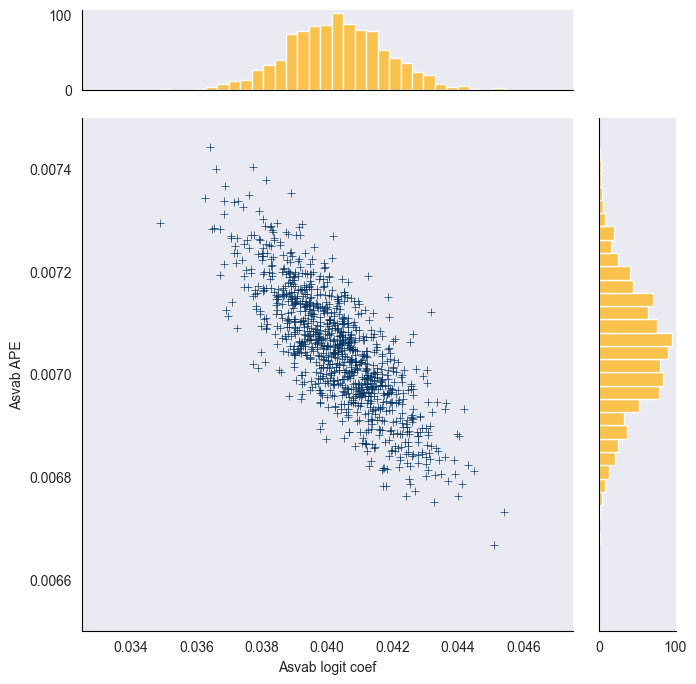

In [23]:
# Construct bootstrap standard error using the percentile interval
norm_ref = sp.stats.norm(loc=0, scale=1)                         # Standard normal reference distribution
se_ape = (upper_bnd-lower_bnd)/(norm_ref.ppf(1-alpha/2)-norm_ref.ppf(alpha/2))
print(f'Standard error (from percentile interval): {se_ape:.6f}')

# Construct bootstrap standard error using the reverse percentile interval
se_ape_rev = (upper_bnd_rev-lower_bnd_rev)/(norm_ref.ppf(1-alpha/2)-norm_ref.ppf(alpha/2))
print(f'Standard error (from reverse percentile interval): {se_ape_rev:.6f}')

# Scatter (use seaborn add-on to matplotlib)
sns.set_style("dark", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
sns.jointplot(x="Asvab logit coef",y="Asvab APE", data=EB, kind="scatter", \
              height=7, space=0.35, color="#003262", xlim=(0.0325,0.0475), ylim=(0.0065,0.0075), marker='+',
              marginal_ticks=True, marginal_kws=dict(bins=30, fill=True, color='#FDB515', linewidth=1))

# Save the figure
plt.savefig(graphics + 'Figure_Reverse Percentile_Bootstrap_Asvab_APE.png', dpi=300, bbox_inches='tight')
plt.show()    

### 1.6 All Coefficients

In [27]:
# Prepare storage for bootstrap results (5 coefficients: intercept, female, black, hispanic, asvab)
M = np.empty((S, 5))

# Perform bootstrap sampling
for s in range(S):
    sth_sample = nlsy97.sample(n=N, replace=True)  # Bootstrap resampling
    X_s = sth_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y_s = sth_sample['college']
    
    # Fit logistic regression model on bootstrap sample
    model_s = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X_s, Y_s)
    M[s, :] = model_s.coef_[0]  # Store all coefficients

# Save bootstrap results into a DataFrame
EB = pd.DataFrame(M, columns=['Intercept', 'Female', 'Black', 'Hispanic', 'ASVAB'])

# Compute percentile-based confidence intervals
bootstrap_ci = np.percentile(M, [alpha/2 * 100, (1 - alpha/2) * 100], axis=0)

# Compute bootstrap standard errors
se_bootstrap = (bootstrap_ci[1] - bootstrap_ci[0]) / (norm_ref.ppf(1 - alpha/2) - norm_ref.ppf(alpha/2))

# Construct percentile confidence interval for ASVAB APE
lower_bnd, upper_bnd = EB["ASVAB"].quantile([alpha/2, 1-alpha/2])

# Compute Reverse Bootstrap SE for each coefficient separately
reverse_lower_bnd = 2 * model.coef_[0] - bootstrap_ci[1]
reverse_upper_bnd = 2 * model.coef_[0] - bootstrap_ci[0]

se_bootstrap_rev = (reverse_upper_bnd - reverse_lower_bnd) / (norm_ref.ppf(1 - alpha/2) - norm_ref.ppf(alpha/2))

# Create results DataFrame with coefficients and standard errors
results_df = pd.DataFrame({
    "Coefficient": model.coef_[0],
    "Bootstrap SE": se_bootstrap,
    "Reverse Bootstrap SE": se_bootstrap_rev
}, index=['Intercept', 'Female', 'Black', 'Hispanic', 'ASVAB'])

results_df

,Coefficient,Bootstrap SE,Reverse Bootstrap SE
Intercept,-3.039104,0.111998,0.111998
Female,0.451547,0.068369,0.068369
Black,0.004648,0.091203,0.091203
Hispanic,-0.186052,0.102379,0.102379
ASVAB,0.040294,0.001522,0.001522


The bootstrap standard error is derived by estimating the variability of the coefficient estimates using repeated resampling. The percentile method constructs a $ (1 - \alpha) \times 100 \% $ confidence interval for $ \beta_k $ by taking the empirical quantiles of the bootstrap estimates. 

Given a confidence interval $ [\beta_k^{\text{lower}}, \beta_k^{\text{upper}}] $, we can work **in reverse** to estimate the standard error $ \text{se}(\hat{\beta_k}) $. The relationship between the confidence interval and standard error follows from the normal approximation:

$$
\beta_k^{\text{upper}} = \hat{\beta_k} + Z_{\alpha/2} \cdot \text{se}(\hat{\beta_k})
$$

$$
\beta_k^{\text{lower}} = \hat{\beta_k} - Z_{\alpha/2} \cdot \text{se}(\hat{\beta_k})
$$

Rearranging this equation, the standard error can be expressed as:

$$
\text{se}(\hat{\beta_k}) = \frac{\beta_k^{\text{upper}} - \beta_k^{\text{lower}}}{2 Z_{\alpha/2}}
$$

Since we **already computed the confidence interval from the bootstrap distribution**, we can use this equation to extract the corresponding standard error. The **reverse percentile method** follows the same logic but reflects the confidence interval around the estimated coefficient, ensuring that the computed variability remains consistent. 

Thus, this method is valid because it leverages the estimated distribution of $ \beta_k $ from the bootstrap, mimicking the standard normal confidence interval calculation but using resampled data instead of theoretical assumptions.

### 1.7 Deriviate Expression

**Verification of the Derivative Expression**

The probability of $Y = 1$ given $X$ in a logistic regression model is:

$$
\Pr(Y = 1 | X = x) = \frac{\exp(\alpha + \sum_{j} \beta_j x_j)}{1 + \exp(\alpha + \sum_{j} \beta_j x_j)}
$$

Taking the derivative with respect to $x_k$:

$$
\frac{\partial \Pr(Y = 1 | X = x)}{\partial x_k} =
\left( \frac{\exp(\alpha + \sum \beta_j x_j)}{1 + \exp(\alpha + \sum \beta_j x_j)} \right)
\left( 1 - \frac{\exp(\alpha + \sum \beta_j x_j)}{1 + \exp(\alpha + \sum \beta_j x_j)} \right) \beta_k
$$

Using the property of the logistic function:

$$
\frac{\exp(z)}{1+\exp(z)} = p, 1-p = \frac{1}{1+\exp(z)}
$$

Rewrite as:

$$
\frac{\partial p}{\partial x_k} = p(1-p)\beta_k
$$

Therefore:

$$
\frac{\partial p}{\partial x_k} = \frac{\exp(\alpha + \sum \beta_j x_j)}{1 + \exp(\alpha + \sum \beta_j x_j)}\beta_k
$$

---

**Derivative Interpretation**

The term  
$$
\frac{\partial \Pr(Y = 1 | X)}{\partial X_k}
$$  
represents the **marginal effect** of a unit increase in $ X_k $ on the probability of $ Y = 1 $ for a given value of $ X $. It shows how much the predicted probability of the outcome changes when we increase $ X_k $ by one unit.

**Expectation Over $ X $**

Instead of evaluating the derivative at a specific $ X $, we take its **expected value over the distribution of $ X $**:
$$
\delta_k^{APE} = \mathbb{E}_X \left[ \frac{\partial \Pr(Y = 1 | X)}{\partial X_k} \right]
$$
This provides an **average effect across all individuals in the population**, rather than just at a single $ X $. Taking the expectation over $ X $ results in:
$$
\delta_k^{APE} = \mathbb{E}_X \left[ \frac{\exp(\alpha + \sum_{j} \beta_j X_j)}{1 + \exp(\alpha + \sum_{j} \beta_j X_j)} \beta_k \right]
$$

---

**Why Do We Need to Average Over $ X $?**

- The effect of $ X_k $ is **not constant** across individuals because the logistic function is nonlinear.
- The marginal effect of $ X_k $ depends on the value of $ X $, meaning that for some individuals, the impact might be larger or smaller.
- By averaging over $ X $, we obtain a **population-level summary measure** of how $ X_k $ influences the probability of $ Y = 1 $.
- This is useful in empirical analysis where we want to report a single interpretable effect rather than a function of $ X $.

Thus, the **APE provides a meaningful summary of how $ X_k $ affects $ Y $ on average across the population**.


### 1.8 Estimate APE

In [28]:
# Compute APE estimate for ASVAB
Xb = X @ model.coef_.T  # Compute linear index
ape_hat_asvab = np.mean((np.exp(Xb) / (1 + np.exp(Xb))**2) * model.coef_[0, -1])

print(f"Estimated APE of ASVAB on College: {ape_hat_asvab:.6f}")

# Bootstrap estimation
S = 1000  # Number of bootstrap samples
M = np.empty(S)  # Store bootstrap APE estimates
N = len(Y)  # Number of observations

for s in range(S):
    # Bootstrap resampling
    boot_sample = nlsy97.sample(n=N, replace=True)
    X_boot = boot_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y_boot = boot_sample['college']

    # Fit new logistic regression
    model_boot = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X_boot, Y_boot)
    
    # Compute APE for bootstrap sample
    Xb_boot = X_boot @ model_boot.coef_.T
    M[s] = np.mean((np.exp(Xb_boot) / (1 + np.exp(Xb_boot))**2) * model_boot.coef_[0, -1])

# Compute 95% Confidence Interval
alpha = 0.05
lower_bnd, upper_bnd = np.percentile(M, [100 * (alpha / 2), 100 * (1 - alpha / 2)])

# Compute Bootstrap Standard Error
se_ape = np.std(M, ddof=1)

print(f"Bootstrap 95% Confidence Interval for APE: {lower_bnd:.6f} to {upper_bnd:.6f}")
print(f"Bootstrap Standard Error for APE: {se_ape:.6f}")

Estimated APE of ASVAB on College: 0.007057
Bootstrap 95% Confidence Interval for APE: 0.006702 to 0.007407
Bootstrap Standard Error for APE: 0.000181


### 1.9 Case Study

**Understanding the Two Measures of Effect on College Completion**

The two measures proposed for estimating the effect of the **college readiness program** are:

1. **First Measure:**
   $$
   \gamma_1^{CR} = \mathbb{E}_X \left[ \frac{\exp(\alpha + \beta_1 X_1 + \dots + \beta_K X_K)}{1 + \exp(\alpha + \beta_1 X_1 + \dots + \beta_K X_K)} \beta_k \right] \times 10
   $$

   - This approach estimates the **Average Partial Effect (APE)** and then **multiplies it by 10**, assuming a **linear approximation** for small changes in \( X_K \).
   - It applies the **marginal effect estimate** to the entire population.

2. **Second Measure:**
   $$
   \gamma_2^{CR} = \mathbb{E}_X \left[ \frac{\exp(\alpha + \beta_1 X_1 + \dots + \beta_K (X_K + 10))}{1 + \exp(\alpha + \beta_1 X_1 + \dots + \beta_K (X_K + 10))} \right] - \mathbb{E}_X \left[ \frac{\exp(\alpha + \beta_1 X_1 + \dots + \beta_K X_K)}{1 + \exp(\alpha + \beta_1 X_1 + \dots + \beta_K X_K)} \right]
   $$

   - This approach **explicitly shifts** \( X_K \) by 10 for each individual before computing the expected probability of college completion.
   - The difference between the **new probability** and the **old probability** gives the predicted effect of the policy change.

In [29]:
# First Measure (γ1_CR)
gamma_1_cr = ape_hat_asvab * 10  # Uses previously computed APE and scales by 10

# Second Measure (γ2_CR)
Xb_shifted = (X @ model.coef_.T) + 10 * model.coef_[0, -1]  # Shift ASVAB by 10
gamma_2_cr = np.mean(np.exp(Xb_shifted) / (1 + np.exp(Xb_shifted))) - np.mean(np.exp(Xb) / (1 + np.exp(Xb)))

# Bootstrap Confidence Intervals
S = 1000
M1, M2 = np.empty(S), np.empty(S)

for s in range(S):
    boot_sample = nlsy97.sample(n=N, replace=True)
    X_boot = boot_sample[['intercept', 'female', 'black', 'hispanic', 'asvab']]
    Y_boot = boot_sample['college']
    
    model_boot = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X_boot, Y_boot)
    
    Xb_boot = X_boot @ model_boot.coef_.T
    ape_boot = np.mean((np.exp(Xb_boot) / (1 + np.exp(Xb_boot))**2) * model_boot.coef_[0, -1])

    M1[s] = ape_boot * 10  # γ1_CR bootstrap
    Xb_boot_shifted = Xb_boot + 10 * model_boot.coef_[0, -1]
    M2[s] = np.mean(np.exp(Xb_boot_shifted) / (1 + np.exp(Xb_boot_shifted))) - np.mean(np.exp(Xb_boot) / (1 + np.exp(Xb_boot)))

# Confidence Intervals
lower1, upper1 = np.percentile(M1, [2.5, 97.5])
lower2, upper2 = np.percentile(M2, [2.5, 97.5])

# Standard Errors
se_γ1 = np.std(M1, ddof=1)
se_γ2 = np.std(M2, ddof=1)

# Print Results
print(f"γ1_CR Estimate: {gamma_1_cr:.6f}, 95% CI: ({lower1:.6f}, {upper1:.6f}), SE: {se_γ1:.6f}")
print(f"γ2_CR Estimate: {gamma_2_cr:.6f}, 95% CI: ({lower2:.6f}, {upper2:.6f}), SE: {se_γ2:.6f}")

γ1_CR Estimate: 0.070568, 95% CI: (0.066867, 0.073960), SE: 0.001826
γ2_CR Estimate: 0.072763, 95% CI: (0.069005, 0.076310), SE: 0.001861


**Do They Differ?**
* Yes, the difference is **small but noticeable**, suggesting that the choice of method matters when estimating the effect of the policy.

**Why Do They Differ?**
1. **Nonlinearity of the Logistic Function**  
   - $ \gamma_1^{CR} $ assumes that the effect of increasing ASVAB is **constant** across individuals and uses the **marginal effect approximation**.  
   - $ \gamma_2^{CR} $ directly **computes the probability change** after shifting ASVAB by 10 points, capturing the **nonlinearity** of the probability function.  
   - Since the logistic function is **sigmoid-shaped**, the marginal effect is **not constant**, which explains why $ \gamma_2^{CR} $ is slightly larger than $ \gamma_1^{CR} $.
2. **Effect of Large Changes in ASVAB**  
   - $ \gamma_1^{CR} $ **multiplies the average partial effect (APE) by 10**, assuming a **linear extrapolation**.  
   - $ \gamma_2^{CR} $ accounts for **how probability changes when ASVAB is actually shifted by 10**, allowing a **more flexible** estimation.

**Potential Issues with These Estimates**
1. **Omitted Variable Bias and Indirect Effects**  
   - Both estimates assume that **only ASVAB changes** and that this **directly** affects college completion.  
   - In reality, increasing ASVAB may be associated with **other unobserved factors**, such as **increased motivation, better school support, or socioeconomic changes**, which these models do not capture.
2. **Extrapolation Bias**  
   - $ \gamma_1^{CR} $ assumes that multiplying by 10 correctly scales the effect, but this may not hold for larger ASVAB changes.  
   - $ \gamma_2^{CR} $ better accounts for nonlinear effects, but it **still assumes that all else remains constant**, which may not be true in reality.

**Conclusion**
* $ \gamma_2^{CR} $ is **likely a better estimate** because it captures nonlinear effects, but both approaches have limitations.  
* A **causal analysis** (e.g., using instrumental variables or experimental data) would be **more reliable** than a simple regression model for predicting policy impacts.


## Part IV: Assessing 'balance'

This final snippet of code constructs a so-called propensity score balance plot. Plots like this one will feature in our discussion of program evaluation and covariate adjustment later in the semester. Note the use of the official [UC Berkeley color pallete](https://brand.berkeley.edu/visual-identity/colors/) in the plot!

In [21]:
X = nlsy97[['intercept', 'female', 'black', 'hispanic', 'asvab']]
Y = nlsy97['college']

model = LogisticRegression(solver='newton-cg', penalty=None, fit_intercept=False).fit(X,Y)
model.coef_

nlsy97['pscore'] = model.predict_proba(X)[:,1] # col 0 gives Pr(Y=0|X),  col 1 gives Pr(Y=1|X)
ps_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['ps_D01', 'ps_D02', 'ps_D03','ps_D04','ps_D05','ps_D06','ps_D07','ps_D08','ps_D09','ps_D10']
nlsy97['ps_level'] = pd.cut(nlsy97['pscore'], bins=ps_bins, labels=labels, right=False)

In [22]:
pd.crosstab(nlsy97['college'], nlsy97['ps_level'], normalize=True, margins=True)

ps_level,ps_D01,ps_D02,ps_D03,ps_D04,ps_D05,ps_D06,ps_D07,ps_D08,ps_D09,All
college,,,,,,,,,,
0,0.148258,0.175574,0.099565,0.069477,0.057799,0.045724,0.036421,0.019794,0.001584,0.654196
1,0.010293,0.032858,0.035629,0.035629,0.041568,0.054632,0.068488,0.060768,0.005938,0.345804
All,0.158551,0.208432,0.135194,0.105107,0.099367,0.100356,0.104909,0.080562,0.007522,1.000000


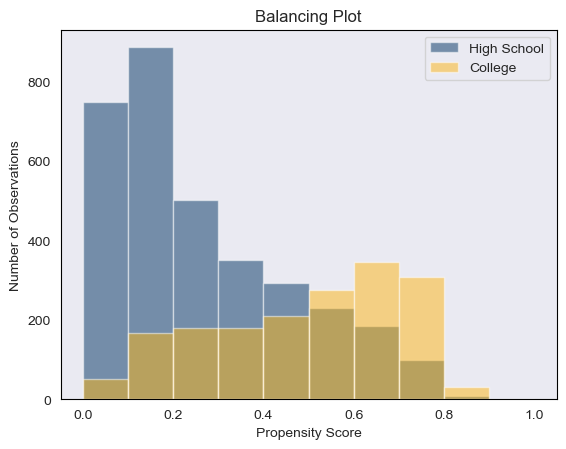

In [23]:
# Create propensity score balance figure
fig, ax = plt.subplots()

# Plot the histograms
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 0)], bins=ps_bins, alpha=0.5, label='High School', color='#003262')
ax.hist(nlsy97['pscore'].loc[(nlsy97['college'] == 1)], bins=ps_bins, alpha=0.5, label='College', color='#FDB515')

# Add labels and title
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Number of Observations')
ax.set_title('Balancing Plot')

# Add legend
ax.legend()

# Show the plot
plt.show()